### (1) Import

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### (2) Contractor

In [ ]:
class ContractingBlock(nn.Module):
  def __init__(self, input_channels):
    super(ContractingBlock, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size = 3)
    self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size = 3)
    self.activation = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.maxpool(x)

    return x

  def get_self(self):
    return self

### (3) crop

In [ ]:
def crop(image, new_shape):
  middle_height = image.shape[2] // 2
  middle_width = image.shape[3] // 2
  starting_height = middle_height - new_shape[2] // 2
  final_height = starting_height + new_shape[2]
  starting_width = middle_width - new_shape[3] // 2
  final_width = starting_width + new_shape[3]
  cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]

  return cropped_image

### 4) expander

In [ ]:
class ExpandingBlock(nn.Module):
  def __init__(self, input_channels):
    super(ExpandingBlock, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
    self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2, stride=1)
    self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size = 3, stride = 1)
    self.activation = nn.ReLU() # each followed by a ReLU

  def forward(self, x, skip_con_x):
    x = self.upsample(x)
    x = self.conv1(x)
    skip_con_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, skip_con_x], axis = 1)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.activation(x)
    return x

  def get_self(self):
    return self


### (5) feature map

In [ ]:
class FeatureMapBlock(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(FeatureMapBlock, self).__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

  def forward(self, x):
    x = self.conv(x)
    return x

### (6) UNet

In [ ]:
class UNet(nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels = 64):
    super(UNet, self).__init__()

    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels)
    self.contract2 = ContractingBlock(hidden_channels * 2)
    self.contract3 = ContractingBlock(hidden_channels * 4)
    self.contract4 = ContractingBlock(hidden_channels * 8)
    self.expand1 = ExpandingBlock(hidden_channels * 16)
    self.expand2 = ExpandingBlock(hidden_channels * 8)
    self.expand3 = ExpandingBlock(hidden_channels * 4)
    self.expand4 = ExpandingBlock(hidden_channels * 2)
    self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

  def forward(self, x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    x4 = self.contract4(x3)
    x5 = self.expand1(x4, x3)
    x6 = self.expand2(x5, x2)
    x7 = self.expand3(x6, x1)
    x8 = self.expand4(x7, x0)
    xn = self.downfeature(x8)
    return xn

### (7) image display

In [ ]:
def show_tensor_images(image_tensor, num_images = 25, size = (1, 28, 28)):
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=4)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

### (8) 기타

### (8-1) 초기화

In [ ]:
import torch.nn.functional as F
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 373
device = "cpu"

### (8-2) 데이터 로딩

In [ ]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('./train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('./train-labels.tif', plugin = "tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

### (9) Training

Epoch : 0, Step : 0, U-Net loss : 0.705263078212738


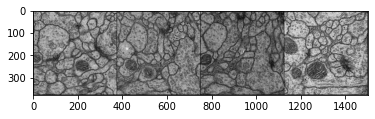

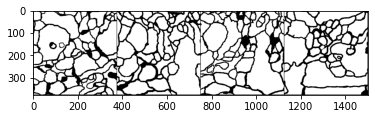

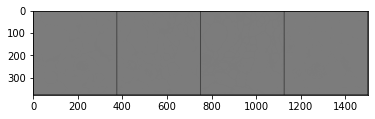

Epoch : 2, Step : 20, U-Net loss : 0.5455119609832764


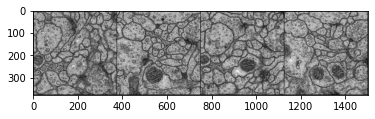

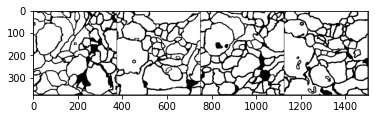

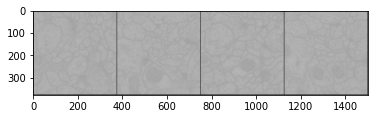

Epoch : 5, Step : 40, U-Net loss : 0.4980843961238861


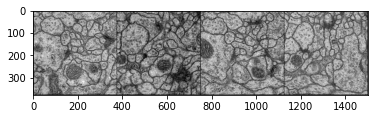

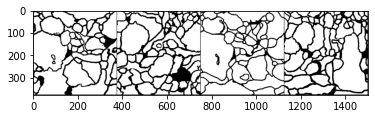

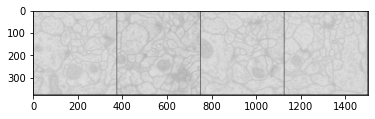

In [ ]:
def train():
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = True
  )
  unet = UNet(input_dim, label_dim).to(device)
  unet_opt = torch.optim.Adam(unet.parameters(), lr = lr)
  cur_step = 0

  for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
      cur_batch_size = len(real)

      # Flatten the image
      real = real.to(device)
      labels = labels.to(device)

      ### update U-Net ###
      unet_opt.zero_grad()
      pred = unet(real)
      unet_loss = criterion(pred, labels)
      unet_loss.backward()
      unet_opt.step()

      if cur_step % display_step == 0:
        print(f"Epoch : {epoch}, Step : {cur_step}, U-Net loss : {unet_loss.item()}")
        show_tensor_images(
            crop(real, torch.Size([len(real), 1, target_shape, target_shape])),
            size = (input_dim, target_shape, target_shape)
        )
        show_tensor_images(labels, size = (label_dim, target_shape, target_shape))
        show_tensor_images(torch.sigmoid(pred), size = (label_dim, target_shape, target_shape))
      cur_step += 1


train()